In [ ]:
# =============================================================================
# CELL 1: Setup and Install Dependencies
# =============================================================================
print("📦 Installing dependencies...")
!pip install -q ultralytics

# Verify GPU
import torch
print(f"\n{'='*70}")
print(f"🎮 CUDA Available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"🎮 GPU: {torch.cuda.get_device_name(0)}")
    print(f"💾 Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
print(f"{'='*70}\n")

📦 Installing dependencies...

🎮 CUDA Available: True
🎮 GPU: Tesla T4
💾 Memory: 15.83 GB



In [ ]:
# =============================================================================
# CELL 2: Mount Google Drive
# =============================================================================
from google.colab import drive
drive.mount('/content/drive')

# Create project folder in Google Drive
!mkdir -p /content/drive/MyDrive/coconut_training
print("✅ Google Drive mounted successfully!")

Mounted at /content/drive
✅ Google Drive mounted successfully!


In [ ]:
# =============================================================================
# CELL 3: Download Dataset from Roboflow
# =============================================================================
"""
OPTION A: Download directly from Roboflow
This is easier than manual upload!
"""

print("📥 Downloading dataset from Roboflow...")
!pip install -q roboflow

from roboflow import Roboflow
import os

# Set download location to Google Drive
download_location = "/content/drive/MyDrive/coconut_datasets"
os.makedirs(download_location, exist_ok=True)

# Change to download directory
os.chdir(download_location)

# Download from Roboflow
rf = Roboflow(api_key="lmMrdcnw3PC2yjMXkj8q")  # Replace with your actual API key
project = rf.workspace("new-otnbm").project("coconut-without-shell-dq9ji-h6aff")
version = project.version(4)
dataset = version.download("yolov11")

print(f"\n✅ Dataset downloaded to: {download_location}")
print(f"📁 Dataset location: {dataset.location}")

# Get the actual dataset path
dataset_path = dataset.location

# Verify download
print("\n📂 Dataset structure:")
!ls -la {dataset_path}

# Move back to /content for consistency with rest of notebook
os.chdir('/content')

# Create a symlink for easier access (optional)
if os.path.exists('/content/coconut_dataset'):
    !rm -rf /content/coconut_dataset

!ln -s {dataset_path} /content/coconut_dataset

print(f"\n✅ Dataset ready at: /content/coconut_dataset")
print(f"✅ Backup saved in: {download_location}")

📥 Downloading dataset from Roboflow...
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Coconut-without-shell-4 in yolov11:: 100%|██████████| 11248/11248 [01:49<00:00, 102.73it/s]



✅ Dataset downloaded to: /content/drive/MyDrive/coconut_datasets
📁 Dataset location: /content/drive/MyDrive/coconut_datasets/Coconut-without-shell-4

📂 Dataset structure:
total 15
-rw------- 1 root root  308 Dec  1 07:46 data.yaml
-rw------- 1 root root  168 Dec  1 07:46 README.dataset.txt
-rw------- 1 root root 1448 Dec  1 07:46 README.roboflow.txt
drwx------ 4 root root 4096 Dec  1 07:46 test
drwx------ 4 root root 4096 Dec  1 07:46 train
drwx------ 4 root root 4096 Dec  1 07:47 valid

✅ Dataset ready at: /content/coconut_dataset
✅ Backup saved in: /content/drive/MyDrive/coconut_datasets


In [ ]:
# =============================================================================
# CORRECT YAML - For FULL Dataset (No Trimming)
# =============================================================================

yaml_content = """# Coconut Full Dataset Configuration
path: /content/drive/MyDrive/coconut_datasets/Coconut-without-shell-4
train: train/images
val: val/images
test: test/images

# Classes
nc: 1
names: ['coconut_no_husk']

# Data Augmentation
hsv_h: 0.015
hsv_s: 0.7
hsv_v: 0.4
degrees: 10.0
translate: 0.1
scale: 0.5
shear: 0.0
perspective: 0.0
flipud: 0.0
fliplr: 0.5
mosaic: 1.0
mixup: 0.0
copy_paste: 0.0
"""

# Save the corrected YAML
with open('/content/coconut.yaml', 'w') as f:
    f.write(yaml_content)

print("✅ YAML Configuration Fixed!")
print("\n" + "="*70)
print(yaml_content)
print("="*70)

# Verify paths exist
import os
base_path = '/content/drive/MyDrive/coconut_datasets/Coconut-without-shell-4'
print("\n🔍 Verifying paths:")
print(f"✓ Train: {os.path.exists(f'{base_path}/train/images')} - {len(os.listdir(f'{base_path}/train/images')) if os.path.exists(f'{base_path}/train/images') else 0} images")
print(f"✓ Val:   {os.path.exists(f'{base_path}/val/images')} - {len(os.listdir(f'{base_path}/val/images')) if os.path.exists(f'{base_path}/val/images') else 0} images")
print(f"✓ Test:  {os.path.exists(f'{base_path}/test/images')} - {len(os.listdir(f'{base_path}/test/images')) if os.path.exists(f'{base_path}/test/images') else 0} images")


✅ YAML Configuration Fixed!

# Coconut Full Dataset Configuration
path: /content/drive/MyDrive/coconut_datasets/Coconut-without-shell-4
train: train/images
val: val/images
test: test/images

# Classes
nc: 1
names: ['coconut_no_husk']

# Data Augmentation
hsv_h: 0.015
hsv_s: 0.7
hsv_v: 0.4
degrees: 10.0
translate: 0.1
scale: 0.5
shear: 0.0
perspective: 0.0
flipud: 0.0
fliplr: 0.5
mosaic: 1.0
mixup: 0.0
copy_paste: 0.0


🔍 Verifying paths:
✓ Train: True - 4626 images
✓ Val:   True - 661 images
✓ Test:  True - 331 images


In [ ]:
from ultralytics import YOLO
import time
from datetime import datetime
import os

print("\n" + "="*70)
print("🚀 STARTING YOLOV11N TRAINING - CLEAN DATASET")
print("="*70)
print(f"⏰ Start time: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"📊 Dataset: 5,623 images (4,630 train / 662 val / 331 test)")
print(f"💾 Checkpoints: Every 5 epochs")
print(f"🎯 Expected time: ~40-50 minutes")
print("="*70 + "\n")

# Check for existing checkpoint
checkpoint_path = '/content/drive/MyDrive/coconut_training/yolo11n_coconut_final/weights/last.pt'
resume_training = os.path.exists(checkpoint_path)

if resume_training:
    print(f"✅ Found existing checkpoint: {checkpoint_path}")
    print("🔄 Resuming training from last checkpoint...\n")
    model = YOLO(checkpoint_path)
else:
    print("ℹ️  No checkpoint found, starting fresh from yolo11n.pt")
    print("🆕 Initializing new training...\n")
    model = YOLO('yolo11n.pt')

# Start training
start_time = time.time()

results = model.train(
    # Dataset
    data='/content/coconut.yaml',

    # Training duration
    epochs=100,
    patience=30,

    # Batch size
    batch=32,

    # Image size
    imgsz=640,

    # Device
    device=0,
    workers=2,

    # Optimizer
    optimizer='AdamW',
    lr0=0.01,
    lrf=0.01,
    momentum=0.937,
    weight_decay=0.0005,

    # Warmup
    warmup_epochs=3.0,
    warmup_momentum=0.8,
    warmup_bias_lr=0.1,

    # Loss weights
    box=7.5,
    cls=0.5,
    dfl=1.5,

    # Augmentation
    hsv_h=0.015,
    hsv_s=0.7,
    hsv_v=0.4,
    degrees=10.0,
    translate=0.1,
    scale=0.5,
    fliplr=0.5,
    mosaic=1.0,
    mixup=0.0,

    # Checkpoints
    save=True,
    save_period=5,

    # Cache & optimization
    cache='ram',
    amp=True,

    # Validation
    val=True,

    # Project
    project='/content/drive/MyDrive/coconut_training',
    name='yolo11n_coconut_final',
    exist_ok=True,  # Changed to True to allow resuming
    pretrained=True,
    verbose=True,
    seed=42,
    deterministic=True,

    # Resume flag
    resume=resume_training,  # Added resume parameter
)

training_time = time.time() - start_time

print("\n" + "="*70)
print("🎉 TRAINING COMPLETED!")
print("="*70)
print(f"⏱️  Total time: {training_time/60:.1f} minutes({training_time/3600:.2f} hours)")
print(f"📁 Best model: {results.save_dir}/weights/best.pt")
print()
print("📊 FINAL METRICS:")
print(f"📈 mAP50:     {results.results_dict.get('metrics/mAP50(B)',0):.4f}")
print(f"📈 mAP50-95:  {results.results_dict.get('metrics/mAP50-95(B)',0):.4f}")
print(f"📈 Precision: {results.results_dict.get('metrics/precision(B)',0):.4f}")
print(f"📈 Recall:    {results.results_dict.get('metrics/recall(B)',0):.4f}")
print("="*70)


🚀 STARTING YOLOV11N TRAINING - CLEAN DATASET
⏰ Start time: 2025-12-01 08:02:03
📊 Dataset: 5,623 images (4,630 train / 662 val / 331 test)
💾 Checkpoints: Every 5 epochs
🎯 Expected time: ~40-50 minutes

Ultralytics 8.3.233 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=32, bgr=0.0, box=7.5, cache=ram, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/coconut.yaml, degrees=10.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11n.pt

In [ ]:
# =============================================================================
# CELL 8: Evaluate Model on Test Set
# =============================================================================

print("\n🔍 EVALUATING MODEL ON TEST SET...\n")
weights_dir = '/content/drive/MyDrive/coconut_training/yolo11n_coconut_final/weights'
# Load best model
best_model_path = f"{weights_dir}/best.pt"
model = YOLO(best_model_path)

# Run validation on test set
test_metrics = model.val(
    data='/content/coconut.yaml',
    split='test',
    batch=32,
    imgsz=640,
    conf=0.25,
    iou=0.45,
    plots=True,
    save_json=True,
    device=0,
)

print("\n" + "="*70)
print("🎯 TEST SET PERFORMANCE")
print("="*70)
print(f"mAP50:     {test_metrics.box.map50:.4f} ({test_metrics.box.map50*100:.2f}%)")
print(f"mAP50-95:  {test_metrics.box.map:.4f} ({test_metrics.box.map*100:.2f}%)")
print(f"Precision: {test_metrics.box.mp:.4f} ({test_metrics.box.mp*100:.2f}%)")
print(f"Recall:    {test_metrics.box.mr:.4f} ({test_metrics.box.mr*100:.2f}%)")
print("="*70)


🔍 EVALUATING MODEL ON TEST SET...

Ultralytics 8.3.233 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.7±0.7 ms, read: 16.8±11.5 MB/s, size: 90.2 KB)
val: Scanning /content/drive/MyDrive/coconut_datasets/Coconut-without-shell-4/test/labels... 331 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 331/331 97.0it/s 3.4s
val: New cache created: /content/drive/MyDrive/coconut_datasets/Coconut-without-shell-4/test/labels.cache
WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 559, len(boxes) = 907. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 11/11 1.5it/s 7.6s
                   all        331        

In [ ]:
# =============================================================================
# CELL 9: Test Predictions on Sample Images
# =============================================================================

print("\n🖼️  TESTING ON SAMPLE IMAGES...\n")

# Define project directory and run name
project_dir = '/content/drive/MyDrive/coconut_training'
run_name = 'yolo11n_coconut_final'

# Predict on test images
predictions = model.predict(
    source='/content/coconut_dataset/test/images',
    save=True,
    conf=0.25,
    iou=0.45,
    imgsz=640,
    save_txt=True,
    save_conf=True,
    save_crop=True,
    project=f"{project_dir}/{run_name}",
    name='test_predictions',
    exist_ok=True,
)

print(f"✅ Predictions saved to: {project_dir}/{run_name}/test_predictions")
print(f"📊 Processed {len(predictions)} images")


🖼️  TESTING ON SAMPLE IMAGES...


image 1/331 /content/coconut_dataset/test/images/105_jpeg.rf.3b077a3b8e594beda32b6b6fc2627050.jpg: 320x640 1 coconut_no_husk, 51.1ms
image 2/331 /content/coconut_dataset/test/images/10_jpg.rf.9bed1cdbb3d0c4bed086333aaa21d503.jpg: 320x640 1 coconut_no_husk, 11.8ms
image 3/331 /content/coconut_dataset/test/images/11_jpeg.rf.019752152b5af7bc2c10839a82d2fb4e.jpg: 320x640 30 coconut_no_husks, 8.0ms
image 4/331 /content/coconut_dataset/test/images/11_jpeg.rf.c40d67fb7ba0e501020f4b20904824c9.jpg: 320x640 29 coconut_no_husks, 30.4ms
image 5/331 /content/coconut_dataset/test/images/12_jpg.rf.6b4badc7c2a80ab954068718965dca3d.jpg: 320x640 2 coconut_no_husks, 10.6ms
image 6/331 /content/coconut_dataset/test/images/15_jpeg.rf.f8171b4920a6f9544fbeaaed9585b1e7.jpg: 320x640 3 coconut_no_husks, 10.2ms
image 7/331 /content/coconut_dataset/test/images/15_jpg.rf.7c96e40cbe5aae6b893ebc4740aa793d.jpg: 320x640 1 coconut_no_husk, 10.1ms
image 8/331 /content/coconut_dataset/t


📊 TRAINING VISUALIZATIONS


📈 Training Results
----------------------------------------------------------------------


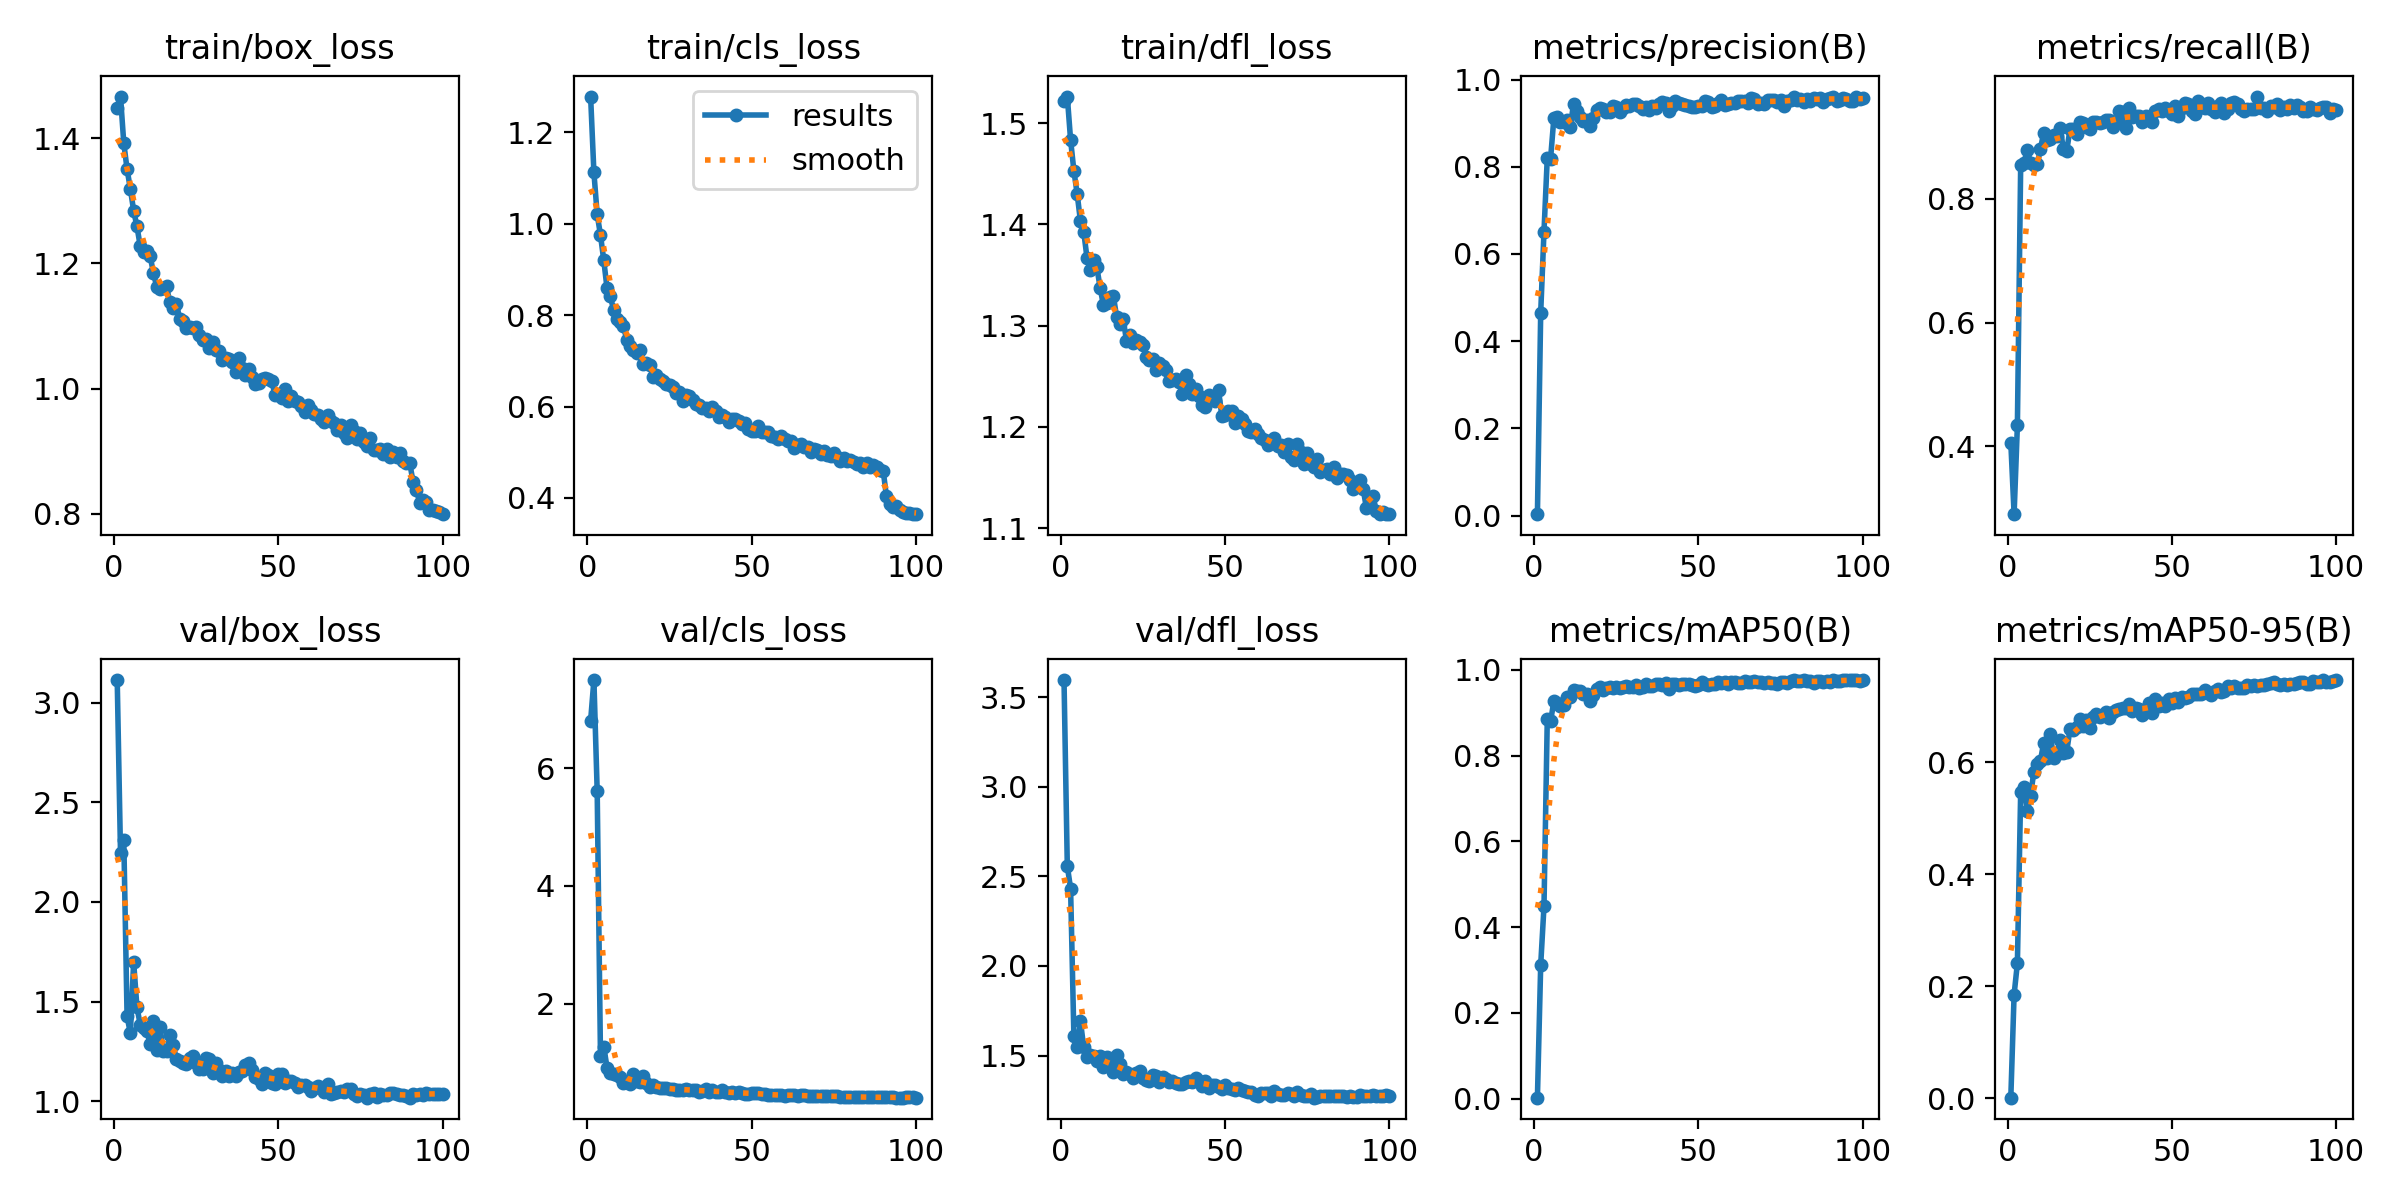


📈 Confusion Matrix
----------------------------------------------------------------------


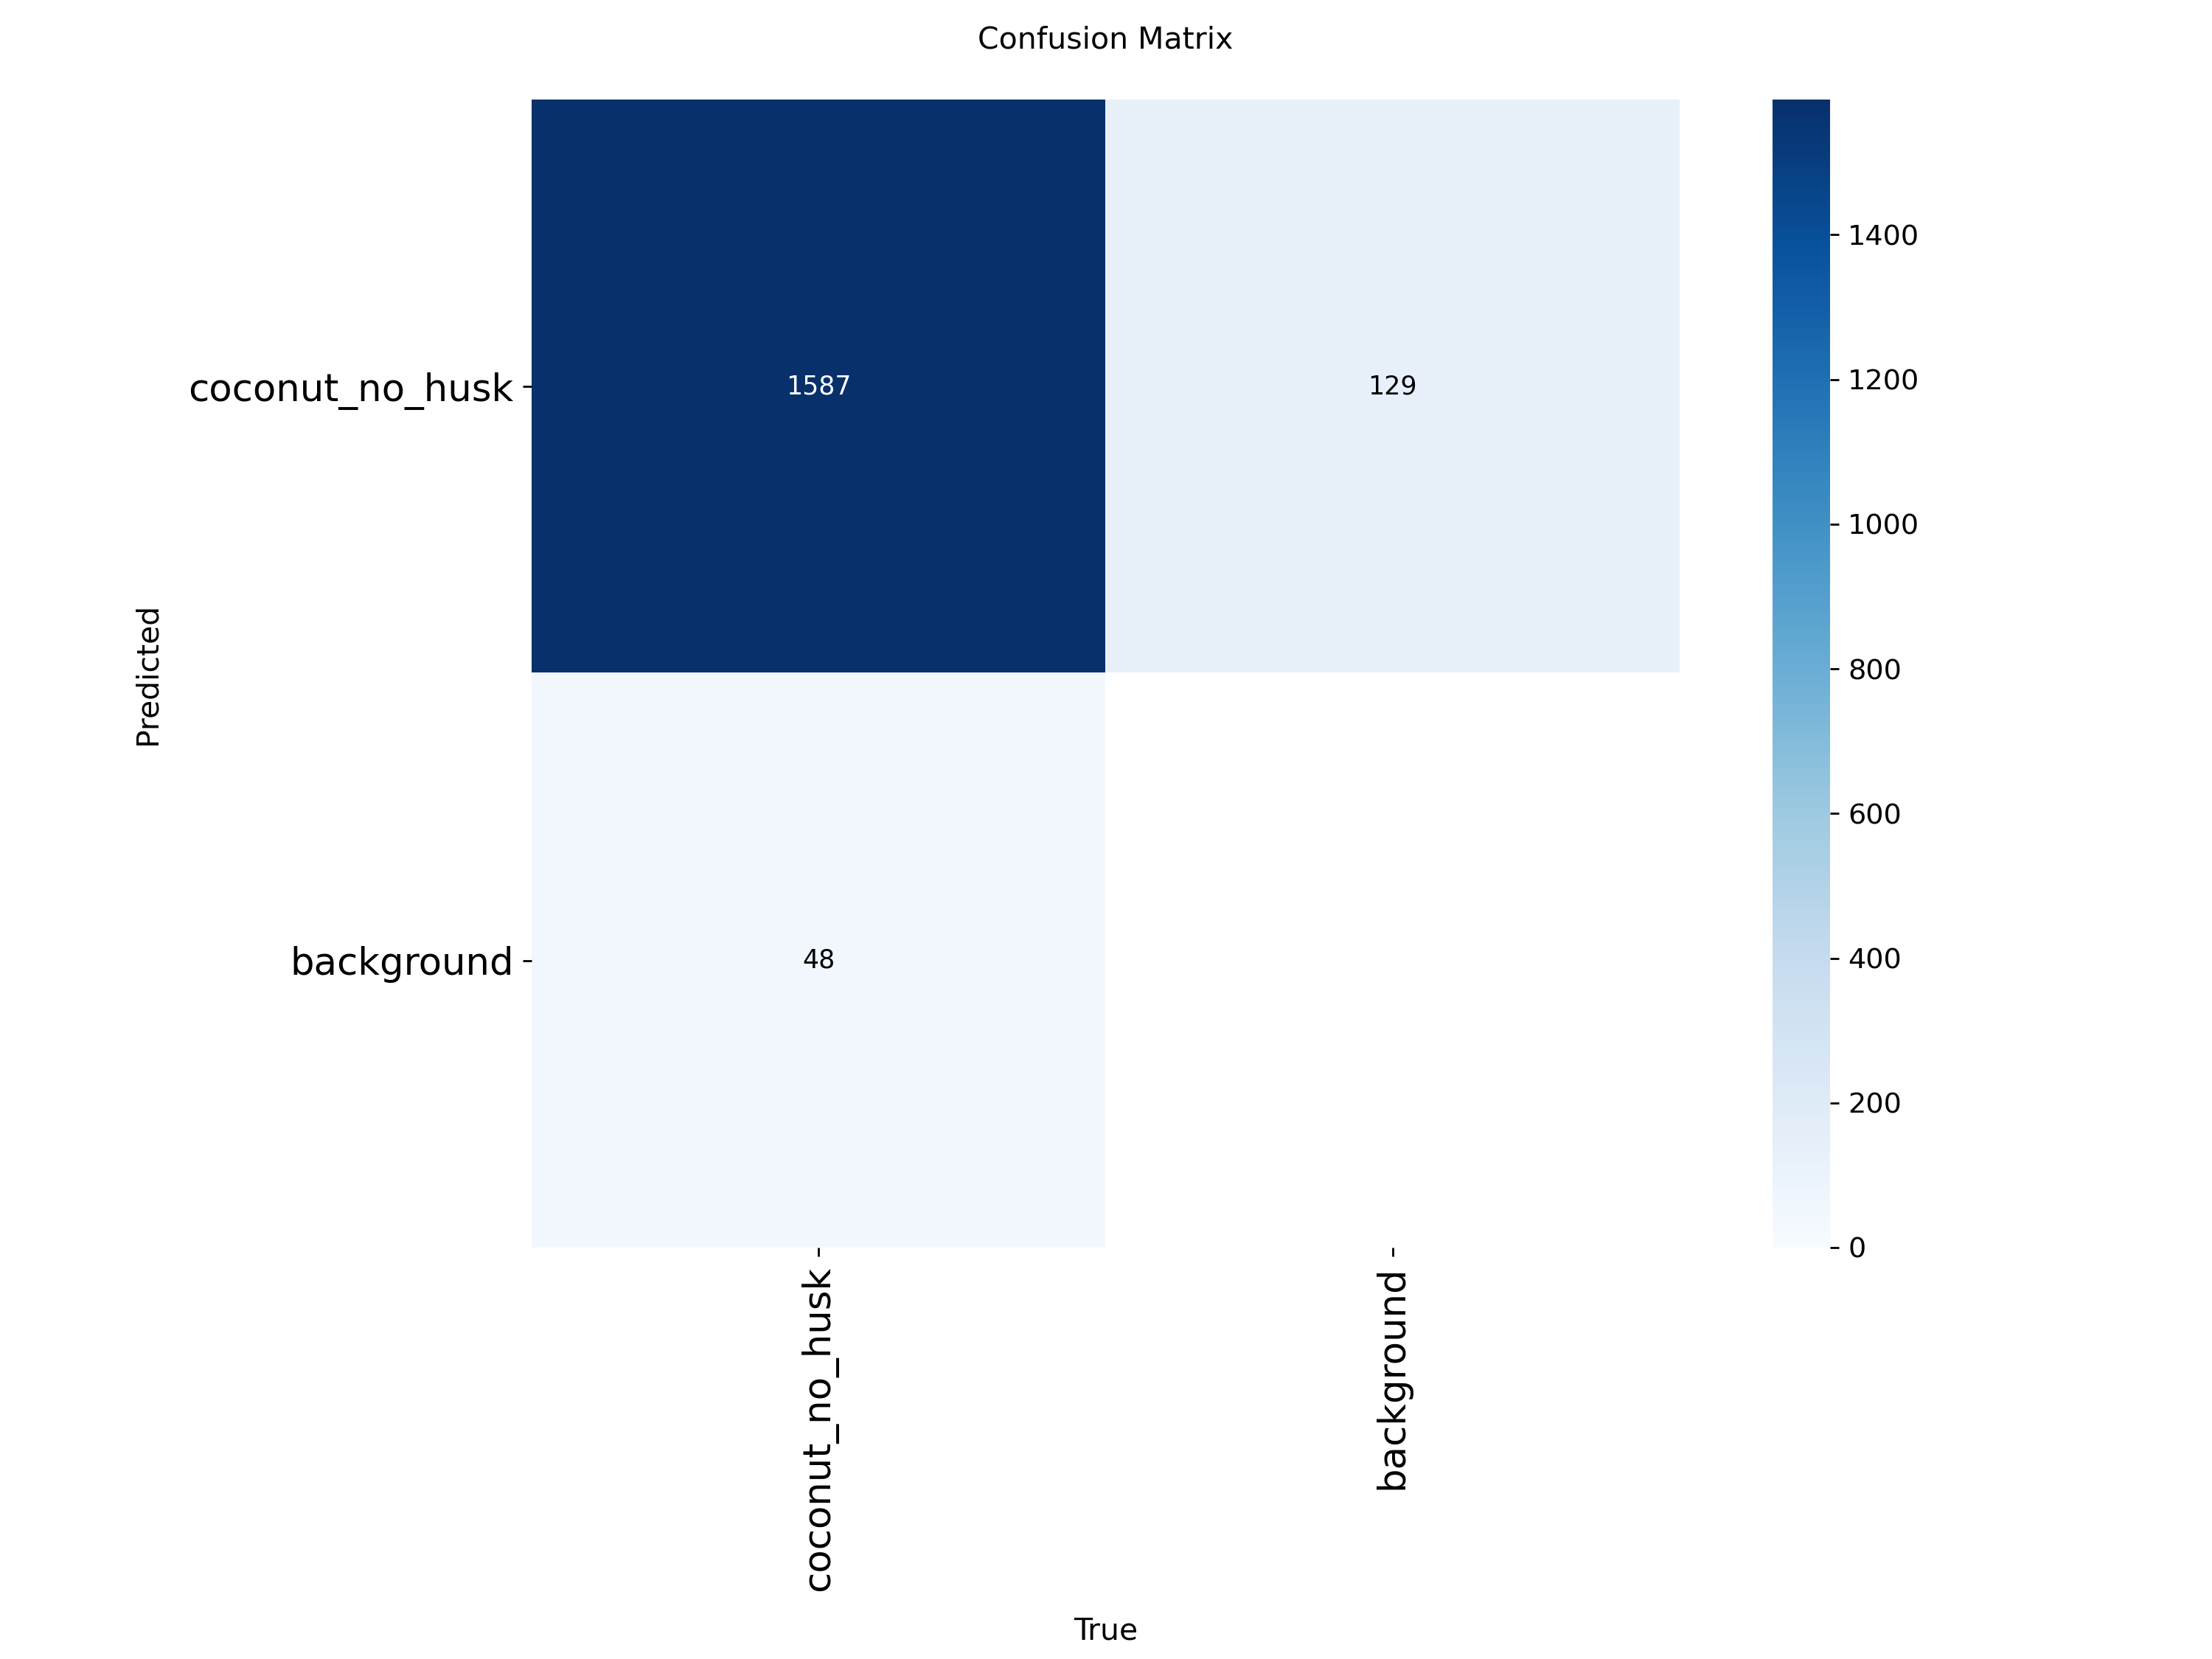

⚠️  F1_curve.png not found
⚠️  P_curve.png not found
⚠️  R_curve.png not found
⚠️  PR_curve.png not found

🖼️  SAMPLE PREDICTIONS

📷 105_jpeg.rf.3b077a3b8e594beda32b6b6fc2627050.jpg


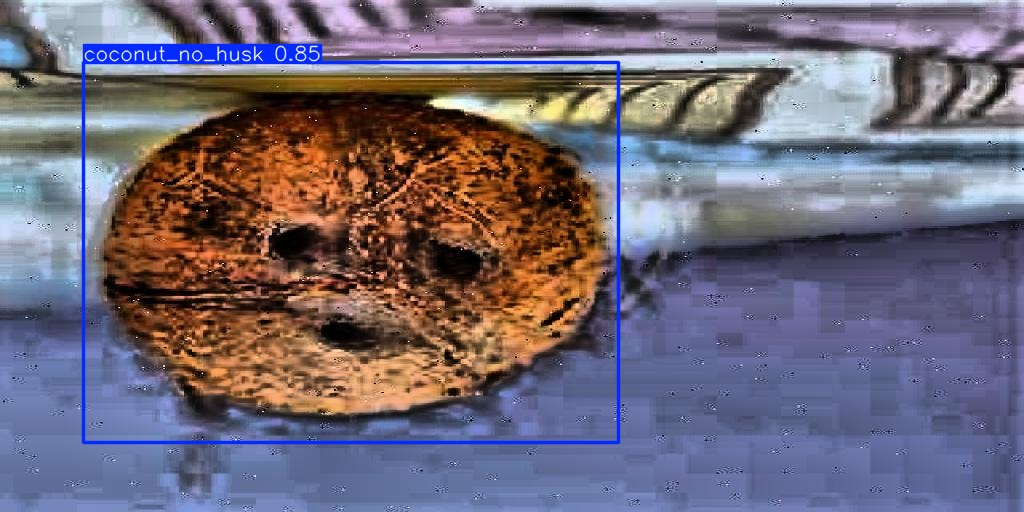


📷 10_jpg.rf.9bed1cdbb3d0c4bed086333aaa21d503.jpg


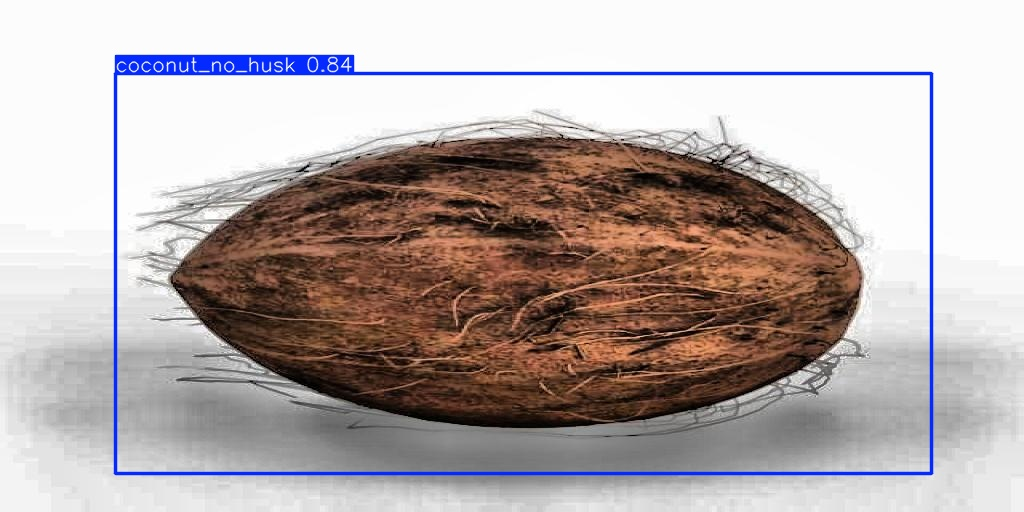


📷 11_jpeg.rf.019752152b5af7bc2c10839a82d2fb4e.jpg


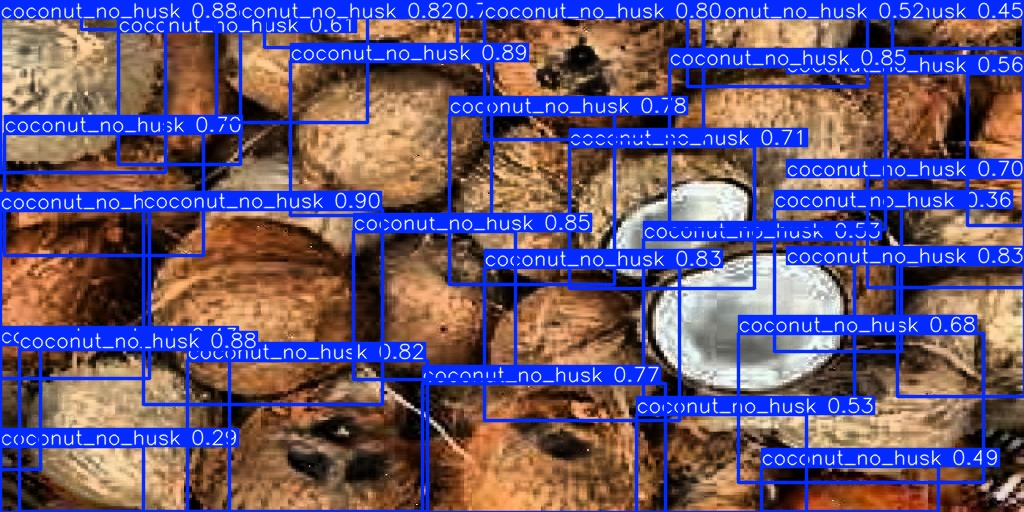


📷 11_jpeg.rf.c40d67fb7ba0e501020f4b20904824c9.jpg


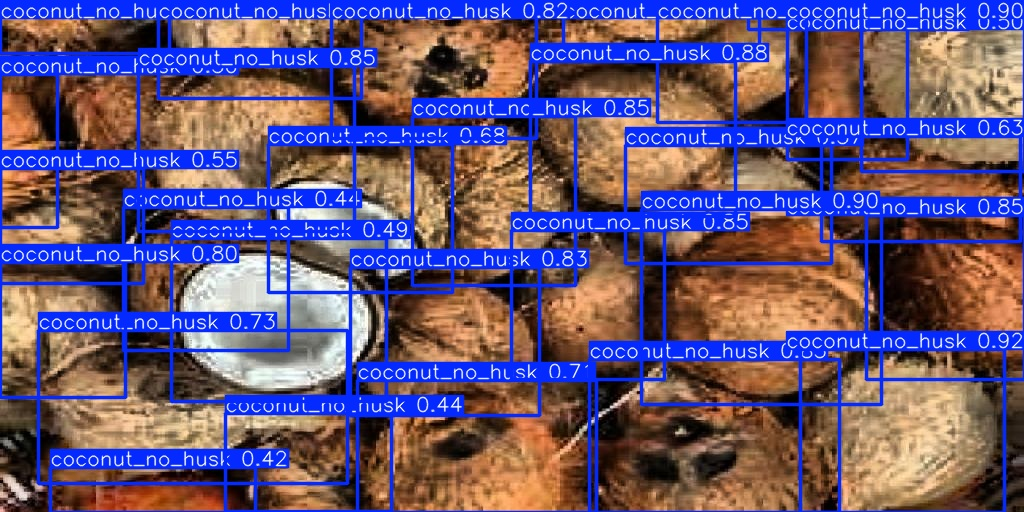


📷 12_jpg.rf.6b4badc7c2a80ab954068718965dca3d.jpg


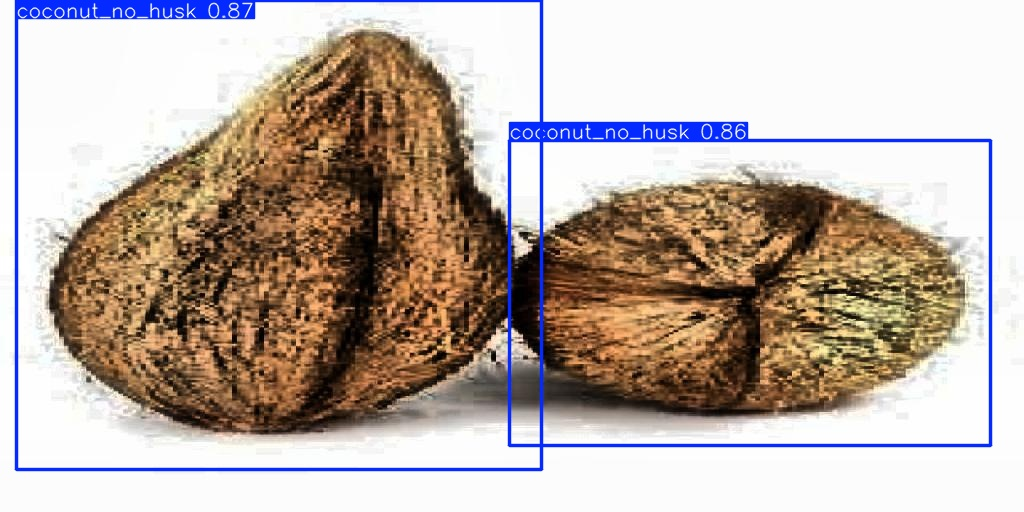

In [ ]:
# =============================================================================
# CELL 10: Visualize Training Results
# =============================================================================

from IPython.display import Image, display
import glob
import os

print("\n" + "="*70)
print("📊 TRAINING VISUALIZATIONS")
print("="*70 + "\n")

result_dir = f"{project_dir}/{run_name}"

# List of result images to display
viz_files = [
    ('results.png', 'Training Results'),
    ('confusion_matrix.png', 'Confusion Matrix'),
    ('F1_curve.png', 'F1 Score Curve'),
    ('P_curve.png', 'Precision Curve'),
    ('R_curve.png', 'Recall Curve'),
    ('PR_curve.png', 'Precision-Recall Curve'),
]

for filename, title in viz_files:
    img_path = f"{result_dir}/{filename}"
    if os.path.exists(img_path):
        print(f"\n📈 {title}")
        print("-" * 70)
        display(Image(filename=img_path, width=900))
    else:
        print(f"⚠️  {filename} not found")

# Display some prediction samples
print("\n" + "="*70)
print("🖼️  SAMPLE PREDICTIONS")
print("="*70 + "\n")

pred_images = glob.glob(f"{result_dir}/test_predictions/*.jpg")[:5]
for img_path in pred_images:
    print(f"📷 {os.path.basename(img_path)}")
    display(Image(filename=img_path, width=700))
    print()



📊 TRAINING VISUALIZATIONS


📈 Training Results
----------------------------------------------------------------------


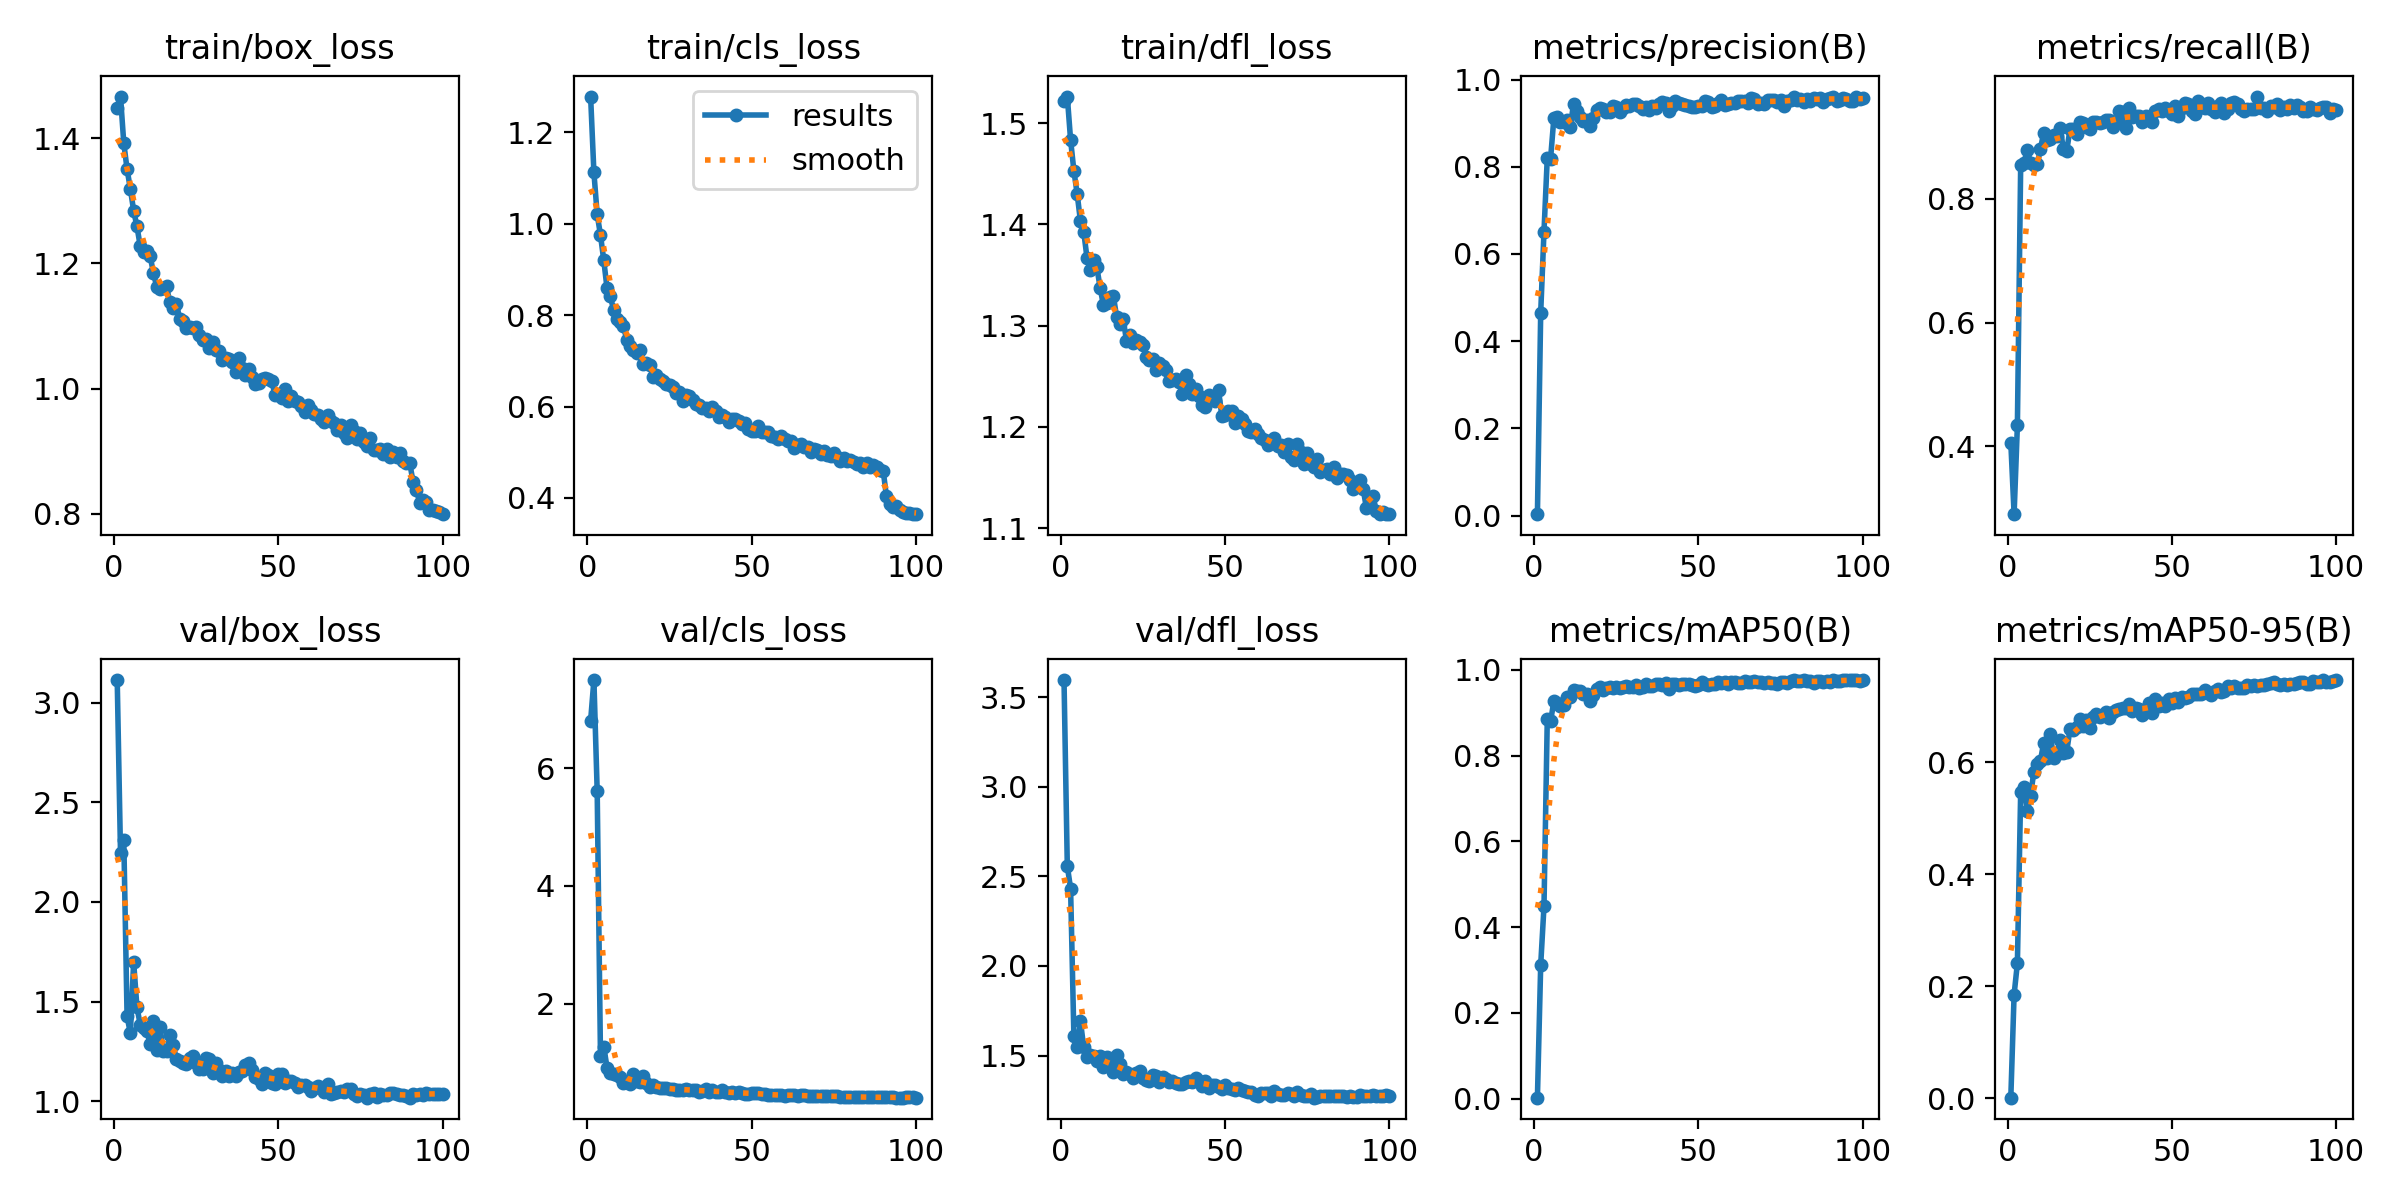


📈 Confusion Matrix
----------------------------------------------------------------------


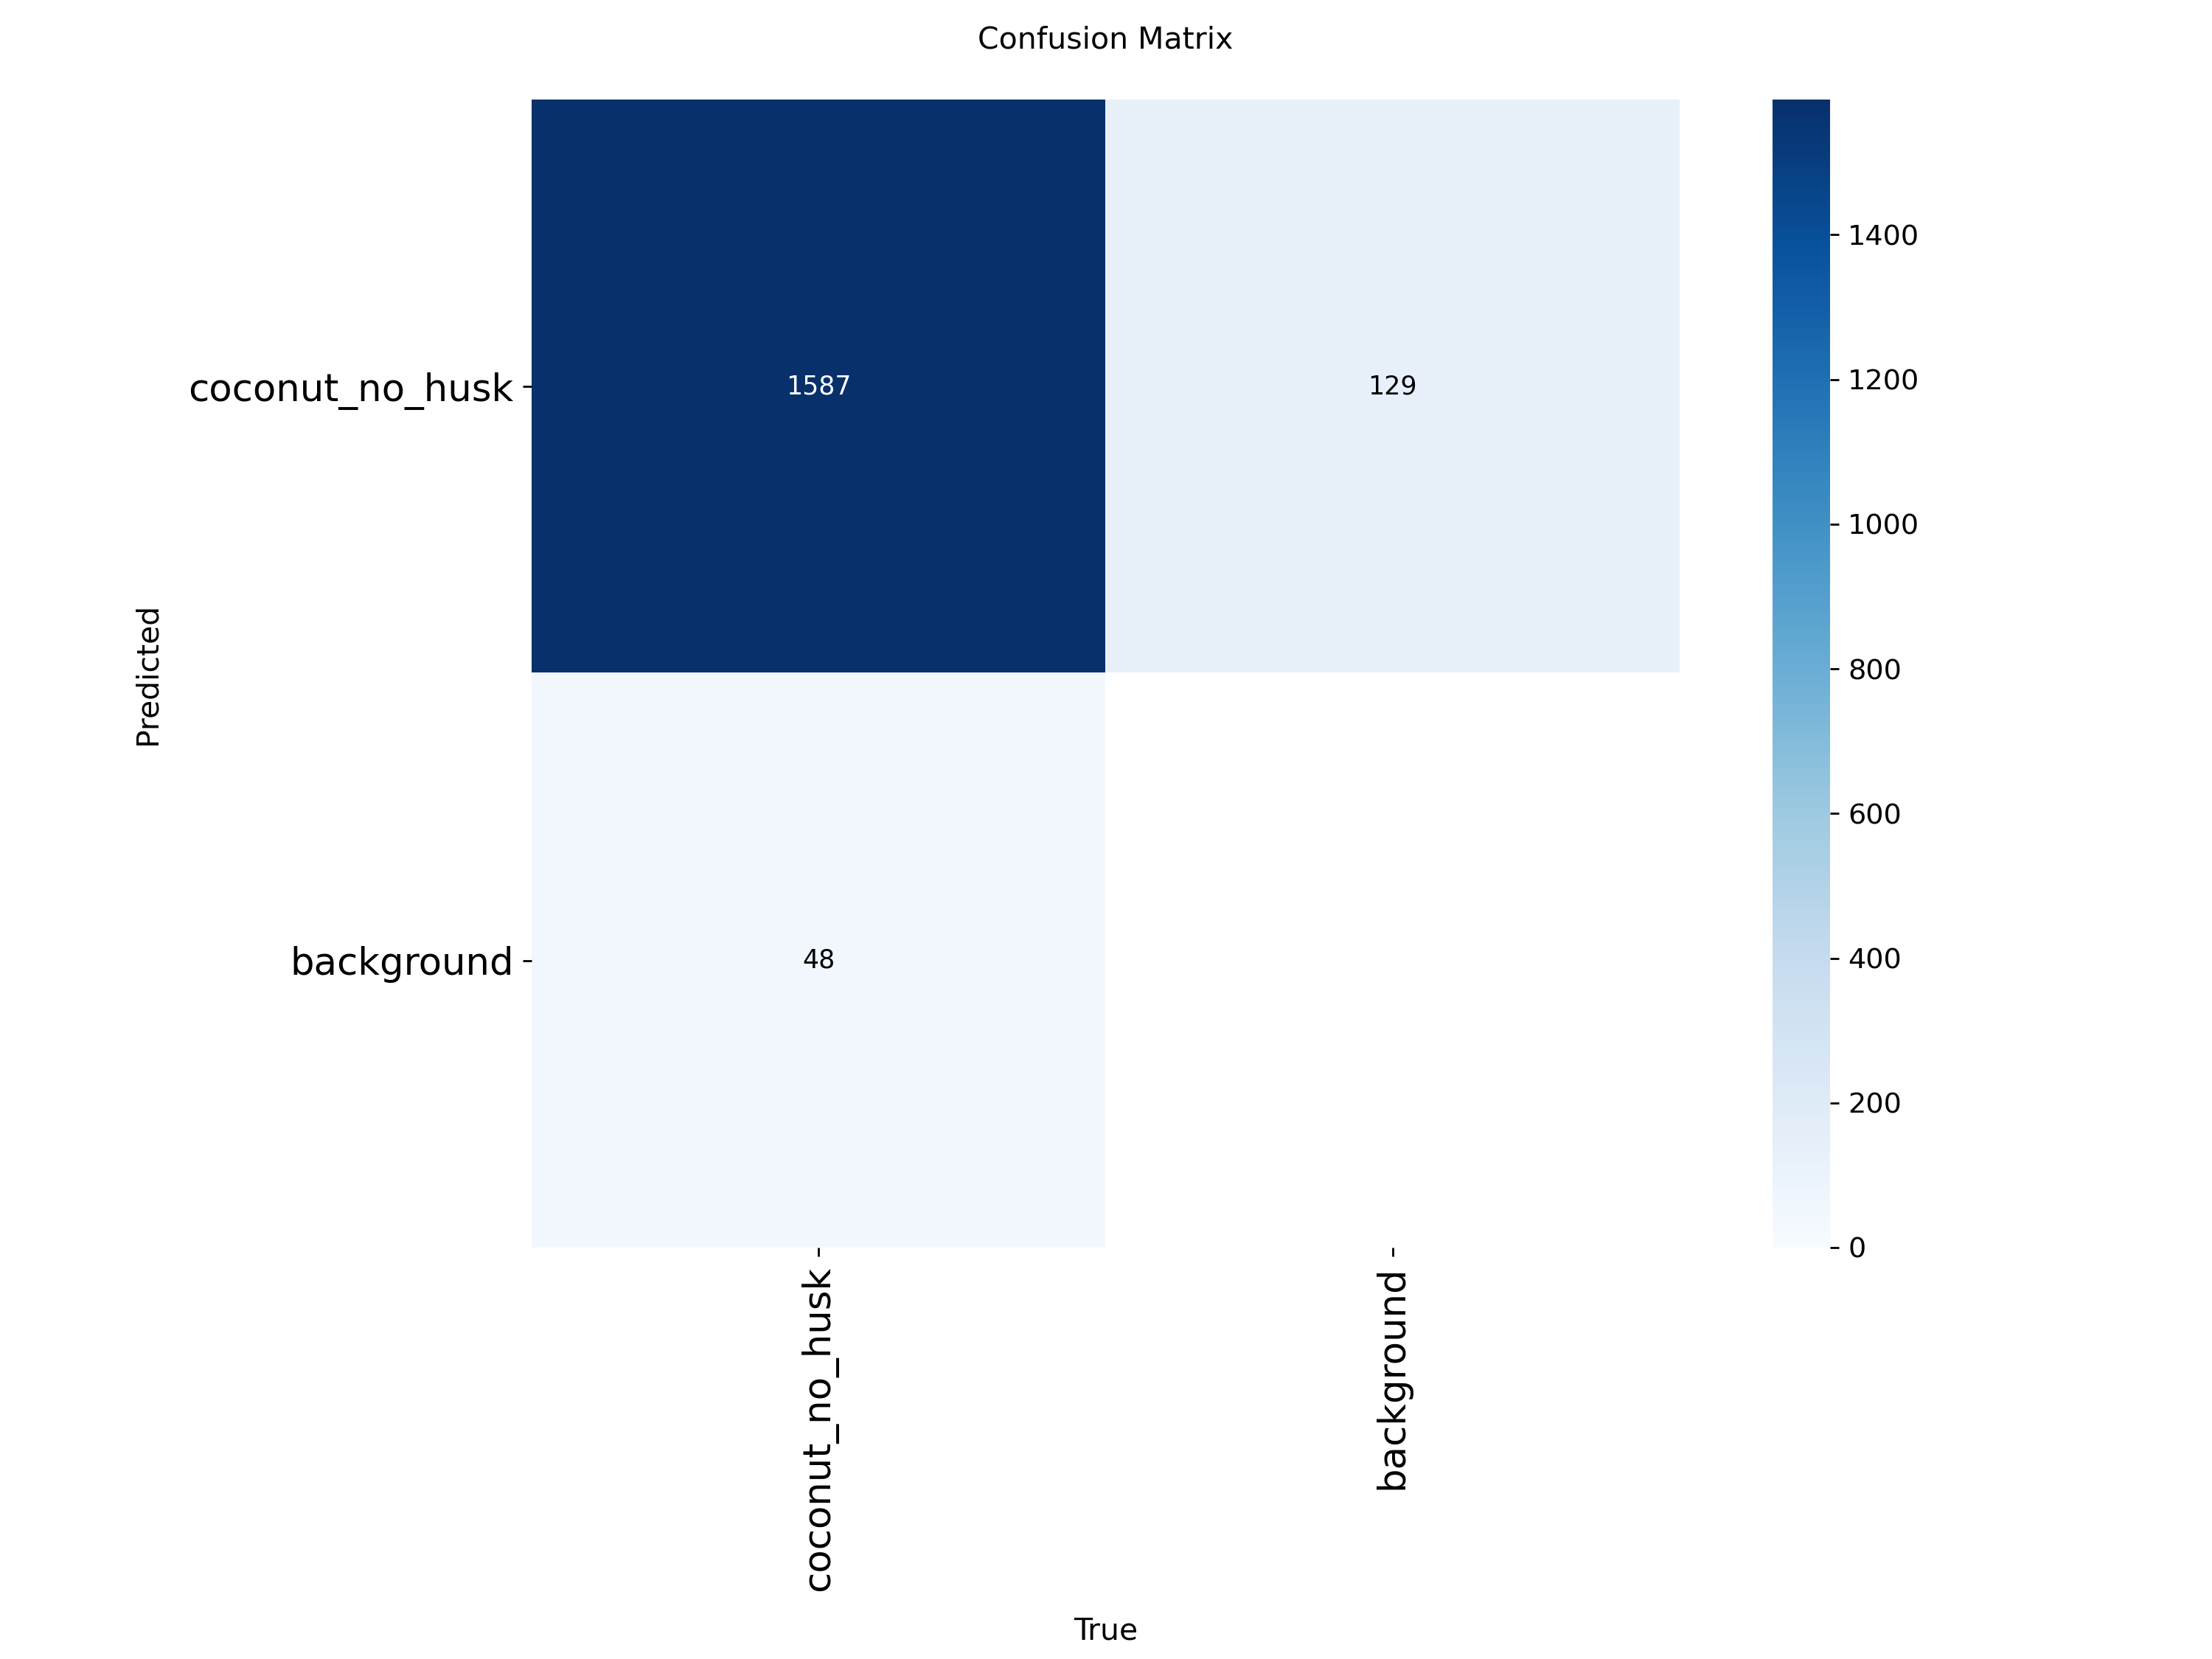

⚠️  F1_curve.png not found
⚠️  P_curve.png not found
⚠️  R_curve.png not found
⚠️  PR_curve.png not found

🖼️  SAMPLE PREDICTIONS

📷 105_jpeg.rf.3b077a3b8e594beda32b6b6fc2627050.jpg


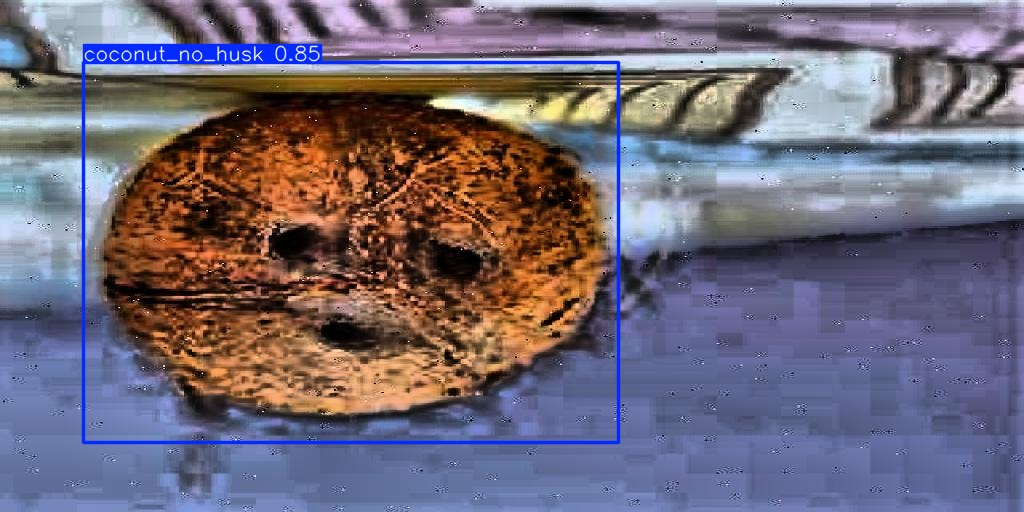


📷 10_jpg.rf.9bed1cdbb3d0c4bed086333aaa21d503.jpg


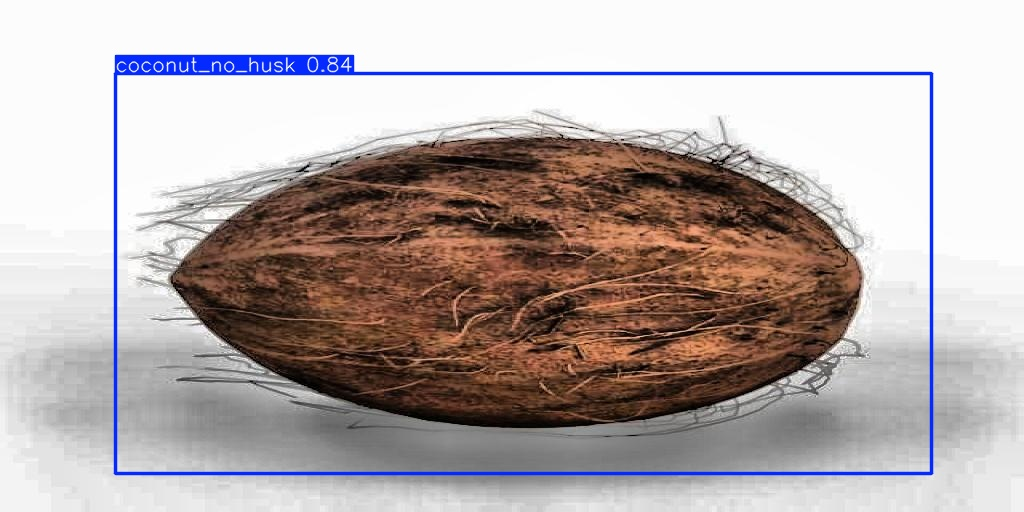


📷 11_jpeg.rf.019752152b5af7bc2c10839a82d2fb4e.jpg


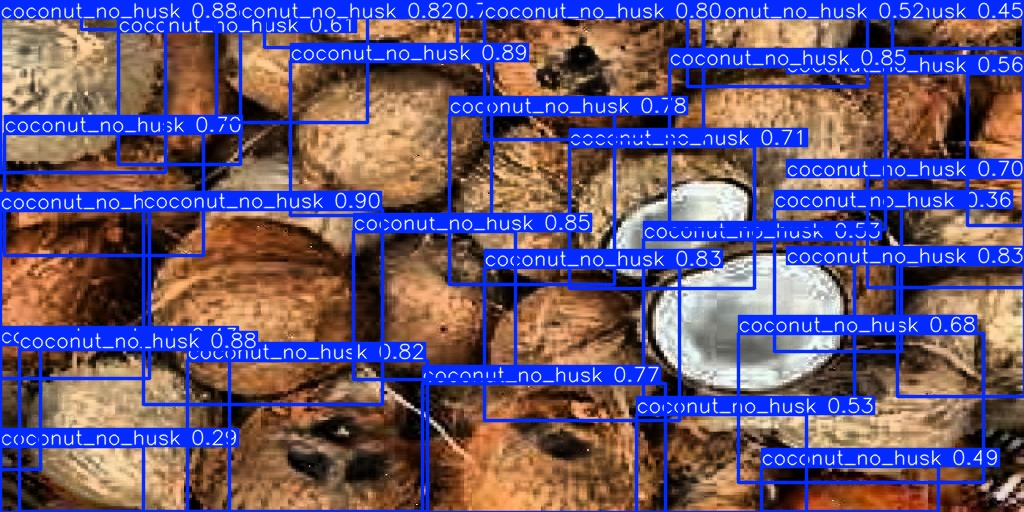


📷 11_jpeg.rf.c40d67fb7ba0e501020f4b20904824c9.jpg


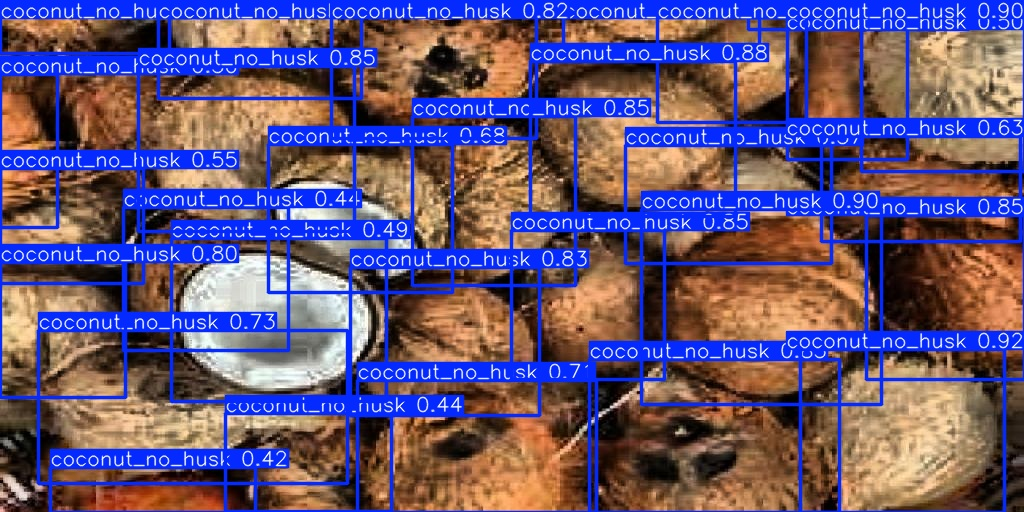


📷 12_jpg.rf.6b4badc7c2a80ab954068718965dca3d.jpg


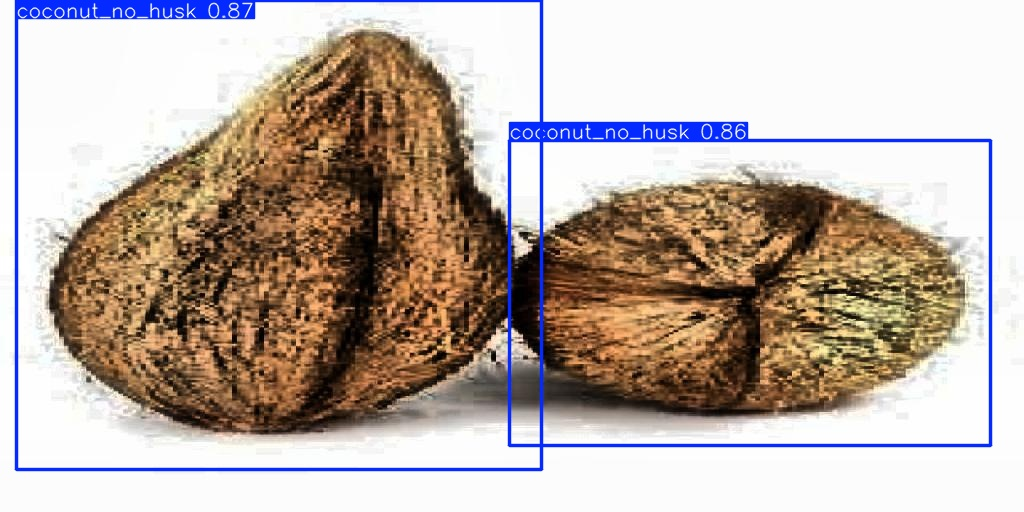

In [ ]:
# =============================================================================
# CELL 10: Visualize Training Results
# =============================================================================

from IPython.display import Image, display
import glob

print("\n" + "="*70)
print("📊 TRAINING VISUALIZATIONS")
print("="*70 + "\n")

result_dir = f"{project_dir}/{run_name}"

# List of result images to display
viz_files = [
    ('results.png', 'Training Results'),
    ('confusion_matrix.png', 'Confusion Matrix'),
    ('F1_curve.png', 'F1 Score Curve'),
    ('P_curve.png', 'Precision Curve'),
    ('R_curve.png', 'Recall Curve'),
    ('PR_curve.png', 'Precision-Recall Curve'),
]

for filename, title in viz_files:
    img_path = f"{result_dir}/{filename}"
    if os.path.exists(img_path):
        print(f"\n📈 {title}")
        print("-" * 70)
        display(Image(filename=img_path, width=900))
    else:
        print(f"⚠️  {filename} not found")

# Display some prediction samples
print("\n" + "="*70)
print("🖼️  SAMPLE PREDICTIONS")
print("="*70 + "\n")

pred_images = glob.glob(f"{result_dir}/test_predictions/*.jpg")[:5]
for img_path in pred_images:
    print(f"📷 {os.path.basename(img_path)}")
    display(Image(filename=img_path, width=700))
    print()

In [ ]:
# =============================================================================
# CELL 11: Export Model to TensorRT (for Jetson)
# =============================================================================

print("\n" + "="*70)
print("🚀 EXPORTING MODEL TO TENSORRT")
print("="*70 + "\n")

print("📦 Exporting best model to TensorRT format...")

# Export to TensorRT Engine
try:
    engine_path = model.export(
        format='engine',
        imgsz=640,
        half=True,  # FP16 for Jetson
        workspace=4,  # 4GB workspace
        device=0,
        simplify=True,
        verbose=True,
    )
    print(f"\n✅ TensorRT model exported successfully!")
    print(f"📁 Engine file: {engine_path}")
except Exception as e:
    print(f"❌ Export failed: {e}")
    print("⚠️  You can export later on Jetson using:")
    print(f"   yolo export model={best_model_path} format=engine half=True")

print("\n" + "="*70)

In [ ]:
# =============================================================================
# CELL 12: List All Available Checkpoints
# =============================================================================

print("\n" + "="*70)
print("💾 AVAILABLE CHECKPOINTS")
print("="*70 + "\n")

checkpoint_dir = f"{weights_dir}"

if os.path.exists(checkpoint_dir):
    checkpoints = glob.glob(f"{checkpoint_dir}/*.pt")

    if checkpoints:
        print(f"Found {len(checkpoints)} checkpoint(s):\n")
        for cp in sorted(checkpoints):
            size = os.path.getsize(cp) / (1024*1024)  # Convert to MB
            print(f"  📄 {os.path.basename(cp):20s} ({size:.1f} MB)")
    else:
        print("⚠️  No checkpoints found")
else:
    print(f"⚠️  Checkpoint directory not found: {checkpoint_dir}")

print("\n" + "="*70)


💾 AVAILABLE CHECKPOINTS

Found 22 checkpoint(s):

  📄 best.pt              (5.2 MB)
  📄 epoch0.pt            (15.3 MB)
  📄 epoch10.pt           (15.3 MB)
  📄 epoch15.pt           (15.3 MB)
  📄 epoch20.pt           (15.3 MB)
  📄 epoch25.pt           (15.3 MB)
  📄 epoch30.pt           (15.3 MB)
  📄 epoch35.pt           (15.3 MB)
  📄 epoch40.pt           (15.3 MB)
  📄 epoch45.pt           (15.3 MB)
  📄 epoch5.pt            (15.3 MB)
  📄 epoch50.pt           (15.3 MB)
  📄 epoch55.pt           (15.3 MB)
  📄 epoch60.pt           (15.3 MB)
  📄 epoch65.pt           (15.3 MB)
  📄 epoch70.pt           (15.3 MB)
  📄 epoch75.pt           (15.3 MB)
  📄 epoch80.pt           (15.3 MB)
  📄 epoch85.pt           (15.3 MB)
  📄 epoch90.pt           (15.3 MB)
  📄 epoch95.pt           (15.3 MB)
  📄 last.pt              (5.2 MB)



In [ ]:
# =============================================================================
# CELL 13: Download Models to Local Machine
# =============================================================================

from google.colab import files

print("\n" + "="*70)
print("⬇️  DOWNLOAD MODELS")
print("="*70 + "\n")

print("Choose what to download:")
print("1. Best PyTorch model (best.pt)")
print("2. TensorRT engine (best.engine) - for Jetson")
print("3. Last checkpoint (last.pt) - to resume training")
print("4. All models")
print()

download_choice = input("Enter choice (1-4): ")

try:
    if download_choice == '1':
        print("⬇️  Downloading best.pt...")
        files.download(f"{weights_dir}/best.pt")

    elif download_choice == '2':
        engine_file = f"{weights_dir}/best.engine"
        if os.path.exists(engine_file):
            print("⬇️  Downloading best.engine...")
            files.download(engine_file)
        else:
            print("❌ TensorRT engine not found. Export it first in Cell 11.")

    elif download_choice == '3':
        print("⬇️  Downloading last.pt...")
        files.download(f"{weights_dir}/last.pt")

    elif download_choice == '4':
        print("⬇️  Downloading all models...")
        for model_file in glob.glob(f"{weights_dir}/*"):
            if model_file.endswith(('.pt', '.engine')):
                print(f"   Downloading {os.path.basename(model_file)}...")
                files.download(model_file)

    print("\n✅ Download complete!")

except Exception as e:
    print(f"❌ Download failed: {e}")
    print("\n💡 Alternative: Access files from Google Drive:")
    print(f"   {project_dir}/{run_name}/weights/")

print("\n" + "="*70)


⬇️  DOWNLOAD MODELS

Choose what to download:
1. Best PyTorch model (best.pt)
2. TensorRT engine (best.engine) - for Jetson
3. Last checkpoint (last.pt) - to resume training
4. All models

Enter choice (1-4): 1
⬇️  Downloading best.pt...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


✅ Download complete!



In [ ]:
! sudo rm -rf coconut_dataset/

In [ ]:
! tree coconut_dataset/ -L 2

coconut_dataset/
├── data.yaml
├── README.dataset.txt
├── README.roboflow.txt
├── test
│   ├── images
│   └── labels
├── train
│   ├── images
│   └── labels
└── val
    ├── images
    └── labels

9 directories, 3 files
